In [26]:
# %pip install matplotlib
# %pip install numpy
# %pip install pandas
# %pip install seaborn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

In [27]:
abm = pd.read_csv("abm.csv")
card = pd.read_csv("card.csv")
cheque = pd.read_csv("cheque.csv")
eft = pd.read_csv("eft.csv")
emt = pd.read_csv("emt.csv")
westernUnion = pd.read_csv("westernunion.csv")
wire = pd.read_csv("wire.csv")

channels = {
    "ABM": abm,
    "Card": card,
    "Cheque": cheque,
    "EFT": eft,
    "EMT": emt,
    "Western Union": westernUnion,
    "Wire": wire
}

kyc_ind = pd.read_csv("kyc_individual.csv")
kyc_ind_codes = pd.read_csv("kyc_industry_codes.csv")
kyc_occ_codes = pd.read_csv("kyc_occupation_codes.csv")
kyc_sb = pd.read_csv("kyc_smallbusiness.csv")
label = pd.read_csv("labels.csv")

# ABM/Cash 
- aiming to capture strcturing & cash cycing:
    - structuring just below thresholds
    - repeated round amounts
    - high-frequency cash usage
    - cash -> electronic outflow patterns

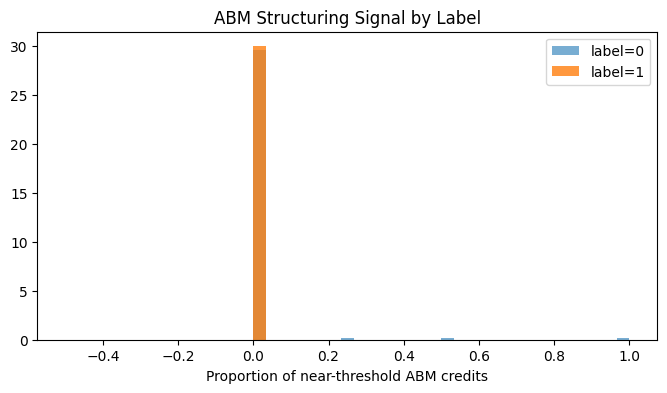

In [28]:
abm_fix = abm.copy()
abm_fix["amount_cad"] = pd.to_numeric(abm_fix["amount_cad"], errors="coerce")
abm_fix["transaction_datetime"] = pd.to_datetime(abm_fix["transaction_datetime"], errors="coerce")

# focus on credits (cash in)
abm_credit = abm_fix[abm_fix["debit_credit"].str.upper() == "C"].dropna(subset=["amount_cad"])

# near-threshold (example: $9k–$10k)
abm_credit["near_threshold"] = abm_credit["amount_cad"].between(9000, 10000)

# round amounts
abm_credit["round_amount"] = abm_credit["amount_cad"] % 1000 == 0

summary = (
    abm_credit
    .groupby("customer_id")[["near_threshold", "round_amount"]]
    .mean()
    .reset_index()
)

summary = summary.merge(label, on="customer_id", how="left")

plt.figure(figsize=(8,4))
plt.hist(summary.loc[summary["label"]==0, "near_threshold"], bins=30, alpha=0.6, density=True, label="label=0")
plt.hist(summary.loc[summary["label"]==1, "near_threshold"], bins=30, alpha=0.8, density=True, label="label=1")
plt.xlabel("Proportion of near-threshold ABM credits")
plt.title("ABM Structuring Signal by Label")
plt.legend()
plt.show()


# research might suggest flagged customers show a higher proportion of near-threshold (i.e. like factor of 10k) and round # ABM credits
# in plot: this is not the case - we see most customers have no near-threshold  or round-amount ABM credits
# ABM deposits at all (both label=0 and label=1 stacked near 0)

# EFT / Wire 
- Pass-Through & Flow-Through Accounts:
    - Rapid in-and-out movement
    - Low fund retention
    - Funnel accounts
- research indicates labeled customers exhibit faster outflows following incoming EFT/Wire credits, consistent with pass-through and layering typologies

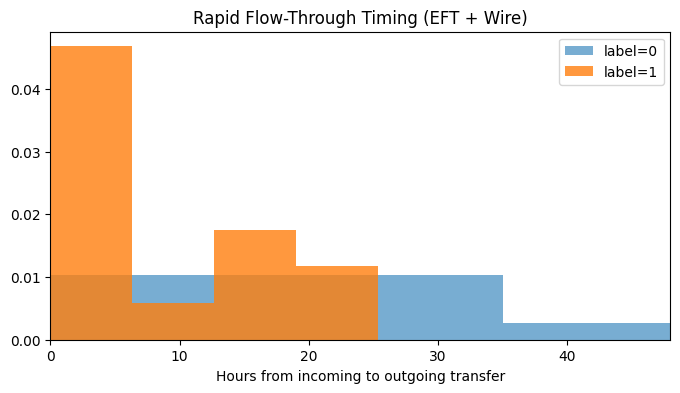

In [29]:
def compute_flow_through(df, channel_name):
    df = df.copy()
    df["transaction_datetime"] = pd.to_datetime(df["transaction_datetime"], errors="coerce")
    df = df.sort_values(["customer_id", "transaction_datetime"])
    
    df["signed_amount"] = np.where(
        df["debit_credit"].str.upper() == "C",
        df["amount_cad"],
        -df["amount_cad"]
    )
    
    df["next_time"] = df.groupby("customer_id")["transaction_datetime"].shift(-1)
    df["next_signed"] = df.groupby("customer_id")["signed_amount"].shift(-1)
    
    # credit followed quickly by debit
    mask = (df["signed_amount"] > 0) & (df["next_signed"] < 0)
    df_ft = df.loc[mask].copy()
    df_ft["hours_to_out"] = (
        (df_ft["next_time"] - df_ft["transaction_datetime"])
        .dt.total_seconds() / 3600
    )
    
    df_ft["channel"] = channel_name
    return df_ft[["customer_id","hours_to_out","channel"]]

ft_eft = compute_flow_through(eft, "EFT")
ft_wire = compute_flow_through(wire, "Wire")

ft = pd.concat([ft_eft, ft_wire], ignore_index=True)
ft = ft.merge(label, on="customer_id", how="left")

plt.figure(figsize=(8,4))
plt.hist(ft.loc[ft["label"]==0, "hours_to_out"], bins=50, alpha=0.6, density=True, label="label=0")
plt.hist(ft.loc[ft["label"]==1, "hours_to_out"], bins=50, alpha=0.8, density=True, label="label=1")
plt.xlim(0, 48)
plt.xlabel("Hours from incoming to outgoing transfer")
plt.title("Rapid Flow-Through Timing (EFT + Wire)")
plt.legend()
plt.show()

# flagged customers pass money more quickly, normal customers tend to hold money longer, consistent with research 

# EMT 
- Smurfing & Multi-Sender Patterns
    - Many small incoming transfers
    - Multiple unrelated senders (proxy via volume clustering)
    - Rapid redistribution
- Low variance in EMT amounts is a classic scripted / mule-collection signal.

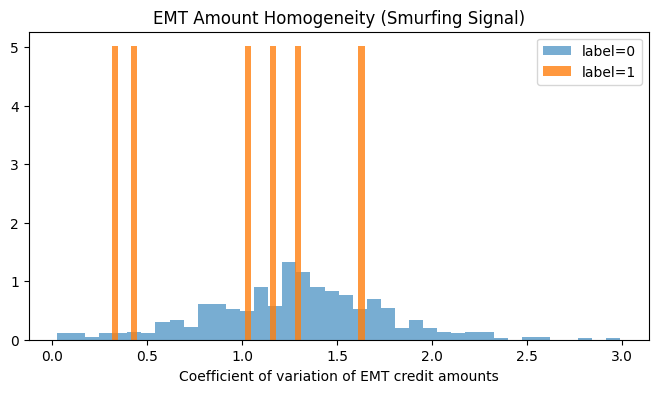

In [30]:
emt_fix = emt.copy()
emt_fix["amount_cad"] = pd.to_numeric(emt_fix["amount_cad"], errors="coerce")

emt_credit = emt_fix[emt_fix["debit_credit"].str.upper()=="C"]

emt_stats = (
    emt_credit
    .groupby("customer_id")["amount_cad"]
    .agg(
        mean_amt="mean",
        std_amt="std",
        n_txns="count"
    )
    .reset_index()
)

emt_stats["cv_amt"] = emt_stats["std_amt"] / emt_stats["mean_amt"]
emt_stats = emt_stats.merge(label, on="customer_id", how="left")

plt.figure(figsize=(8,4))
plt.hist(emt_stats.loc[emt_stats["label"]==0, "cv_amt"], bins=40, alpha=0.6, density=True, label="label=0")
plt.hist(emt_stats.loc[emt_stats["label"]==1, "cv_amt"], bins=40, alpha=0.8, density=True, label="label=1")
plt.xlabel("Coefficient of variation of EMT credit amounts")
plt.title("EMT Amount Homogeneity (Smurfing Signal)")
plt.legend()
plt.show()

# this plot does indicate difference between normal and flagged customers in how similar their EMT amounts are
# no strong evidence of smurfing 

# Card
- Spend Laundering & Integration
    - High transaction counts
    - Small-ticket layering
    - E-commerce concentration

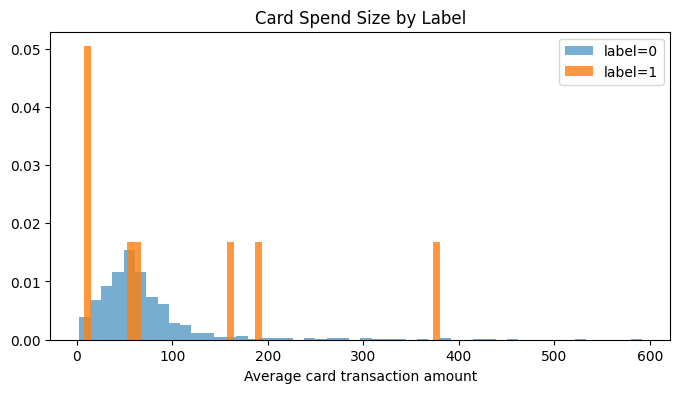

/tmp/ipykernel_2930966/3961108742.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


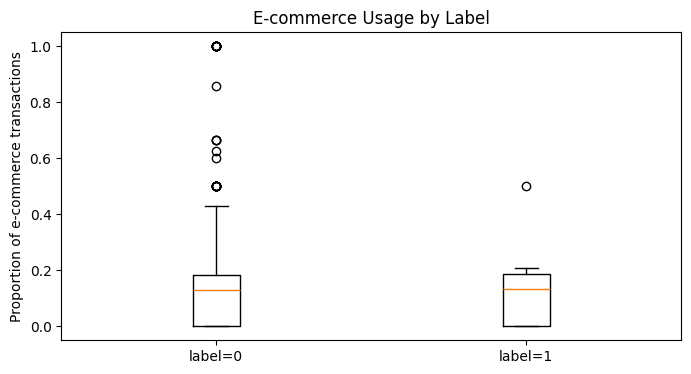

In [31]:
card_fix = card.copy()
card_fix["amount_cad"] = pd.to_numeric(card_fix["amount_cad"], errors="coerce")

card_stats = (
    card_fix
    .groupby("customer_id")
    .agg(
        total_card_txns=("amount_cad","count"),
        avg_card_amt=("amount_cad","mean"),
        ecommerce_rate=("ecommerce_ind","mean")
    )
    .reset_index()
)

card_stats = card_stats.merge(label, on="customer_id", how="left")

plt.figure(figsize=(8,4))
plt.hist(card_stats.loc[card_stats["label"]==0, "avg_card_amt"], bins=50, alpha=0.6, density=True, label="label=0")
plt.hist(card_stats.loc[card_stats["label"]==1, "avg_card_amt"], bins=50, alpha=0.8, density=True, label="label=1")
plt.xlabel("Average card transaction amount")
plt.title("Card Spend Size by Label")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.boxplot(
    [
        card_stats.loc[card_stats["label"]==0, "ecommerce_rate"].dropna(),
        card_stats.loc[card_stats["label"]==1, "ecommerce_rate"].dropna()
    ],
    labels=["label=0","label=1"]
)
plt.ylabel("Proportion of e-commerce transactions")
plt.title("E-commerce Usage by Label")
plt.show()

# in plot: flagged customers don't appear to spend differently on card
# similar dollar spend amount and proportion of transactions as normal customers 

# Cross-Channel Funnel Patterns
- Cash -> electronic -> depletion
- Multi-rail laundering

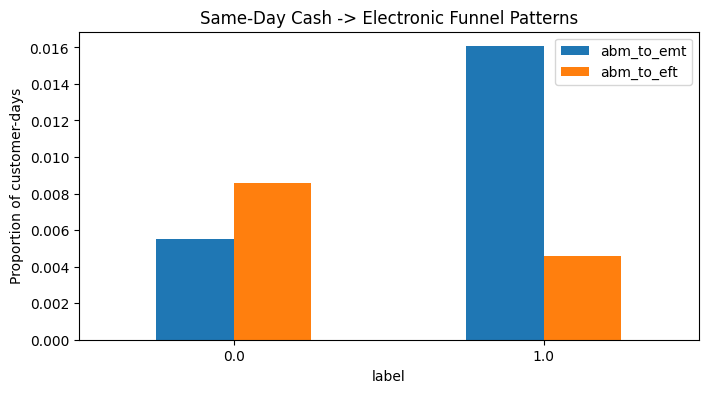

In [32]:
def prep_channel(df, channel_name):
    out = df[["customer_id", "transaction_datetime"]].copy()
    out["transaction_datetime"] = pd.to_datetime(out["transaction_datetime"], errors="coerce")
    out["date"] = out["transaction_datetime"].dt.date
    out["channel"] = channel_name
    return out

all_txns = pd.concat([
    prep_channel(abm, "ABM"),
    prep_channel(card, "Card"),
    prep_channel(cheque, "Cheque"),
    prep_channel(eft, "EFT"),
    prep_channel(emt, "EMT"),
    prep_channel(westernUnion, "WesternUnion"),
    prep_channel(wire, "Wire")
], ignore_index=True)

cust_day_channel = (
    all_txns
    .groupby(["customer_id", "date", "channel"])
    .size()
    .rename("n_txns")
    .reset_index())

cust_day_channel_flag = (
    cust_day_channel
    .assign(present=1)
    .pivot_table(
        index=["customer_id","date"],
        columns="channel",
        values="present",
        fill_value=0
    )
    .reset_index()
)

cust_day_channel_flag = cust_day_channel_flag.merge(label, on="customer_id", how="left")

cust_day_channel_flag["abm_to_emt"] = (
    (cust_day_channel_flag.get("ABM",0)==1) &
    (cust_day_channel_flag.get("EMT",0)==1)
)

cust_day_channel_flag["abm_to_eft"] = (
    (cust_day_channel_flag.get("ABM",0)==1) &
    (cust_day_channel_flag.get("EFT",0)==1)
)

funnel_rates = (
    cust_day_channel_flag
    .groupby("label")[["abm_to_emt","abm_to_eft"]]
    .mean()
)

funnel_rates.plot(kind="bar", figsize=(8,4))
plt.ylabel("Proportion of customer-days")
plt.title("Same-Day Cash -> Electronic Funnel Patterns")
plt.xticks(rotation=0)
plt.show()

# flagged customers are more likely to withdraw cash and move it electronically the same day via EMT
# suggests channel-specific risk 

## Channel Specific Behvaiours

- Professional laundering networks often specialize channels
- Mule networks show unnatural diversity or unnatural concentration

- Do risky customers specialize in 1–2 channels or show broad channel usage?

---

(from chat - use HHI to quantify channel usage)

https://www.investopedia.com/terms/h/hhi.asp 

Herfindahl-Hirschman Index - size of company relative to industry they're in -> measure of market concentration 
- High HHI -> channel specialization (eg mule using EMT only)
- Low HHI -> unusual breadth (possible layering)

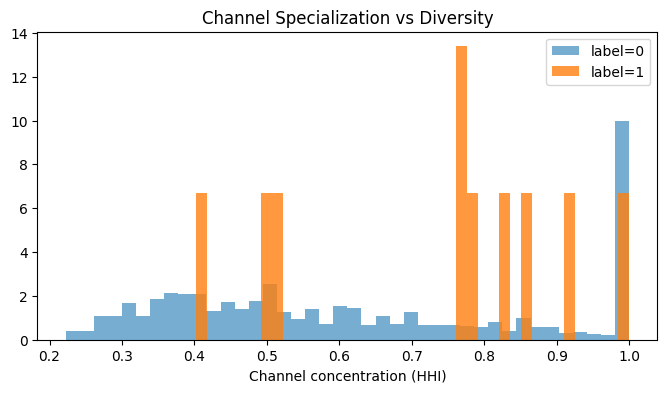

In [33]:
channel_dist = (
    all_txns
    .groupby(["customer_id","channel"])
    .size()
    .rename("n")
    .reset_index()
)

channel_totals = channel_dist.groupby("customer_id")["n"].sum().rename("total")

channel_dist = channel_dist.merge(channel_totals, on="customer_id")
channel_dist["p"] = channel_dist["n"] / channel_dist["total"]

# Herfindahl-Hirschman Index
hhi = (
    channel_dist
    .groupby("customer_id")["p"]
    .apply(lambda x: (x**2).sum())
    .rename("channel_hhi")
    .reset_index()
)

hhi = hhi.merge(label, on="customer_id", how="left")

plt.figure(figsize=(8,4))
plt.hist(hhi.loc[hhi["label"]==0,"channel_hhi"], bins=40, alpha=0.6, density=True, label="label=0")
plt.hist(hhi.loc[hhi["label"]==1,"channel_hhi"], bins=40, alpha=0.8, density=True, label="label=1")
plt.xlabel("Channel concentration (HHI)")
plt.title("Channel Specialization vs Diversity")
plt.legend()
plt.show()

# Plot: (y-axis density - height difference due to sample size)
# Most non-flagged (ie label 0) don't have specific concentration for channel use 
# For flagged accounts, cluster at higher values => channel specialization; cluster at moderate 
# values (0.4-0.5) might suggest other risk factors

## Channel role asymmetry (where money comes in vs goes out)
- Cash channels = placement
- EFT/Wire = layering
- Card = integration

- Are channels used asymmetrically for credits vs debits?

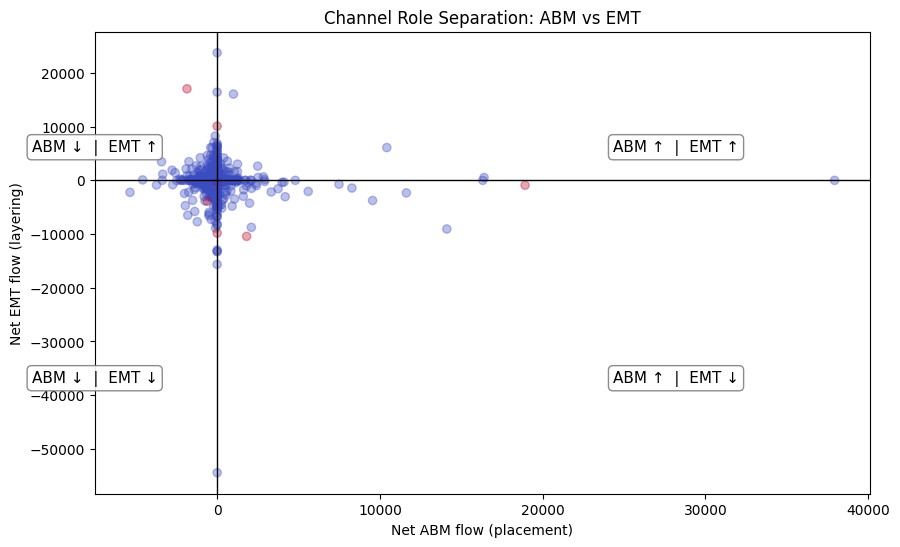

In [34]:
def channel_role_summary(df, name):
    df = df.copy()
    df["signed_amt"] = np.where(
        df["debit_credit"].str.upper()=="C",
        df["amount_cad"],
        -df["amount_cad"]
    )
    out = (
        df.groupby("customer_id")["signed_amt"]
        .sum()
        .rename(f"net_{name}")
        .reset_index()
    )
    return out

net_abm = channel_role_summary(abm, "ABM")
net_emt = channel_role_summary(emt, "EMT")
net_wire = channel_role_summary(wire, "Wire")

net_flow = net_abm.merge(net_emt, on="customer_id", how="outer") \
                  .merge(net_wire, on="customer_id", how="outer") \
                  .fillna(0)

net_flow = net_flow.merge(label, on="customer_id", how="left")

fig, ax = plt.subplots(figsize=(10, 6))

sc = ax.scatter(
    net_flow["net_ABM"],
    net_flow["net_EMT"],
    alpha=0.35,
    c=net_flow["label"],
    cmap="coolwarm"
)

ax.axvline(0, color="black", linewidth=1)
ax.axhline(0, color="black", linewidth=1)

ax.set_xlabel("Net ABM flow (placement)")
ax.set_ylabel("Net EMT flow (layering)")
ax.set_title("Channel Role Separation: ABM vs EMT")

kw = dict(transform=ax.transAxes, fontsize=11, ha="center", va="center",
          bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

ax.text(0.75, 0.75, "ABM ↑  |  EMT ↑", **kw)  # top-right
ax.text(-0.0001, 0.75, "ABM ↓  |  EMT ↑", **kw)  # top-left
ax.text(-0.0001, 0.25, "ABM ↓  |  EMT ↓", **kw)  # bottom-left
ax.text(0.75, 0.25, "ABM ↑  |  EMT ↓", **kw)  # bottom-right

plt.show()

# normal customers clustered around (0, 0) -> balanced ABM/EMT activity (inflow ~= outflow over time)
# flagged accounts (in red) are in more extremes -> e.g. high ABM, low EMT 
# off-diagonal behaviour is more suspicious because it would mean high inflow and little outflow, but would 
# average out to be equal over time in normal customer use 

## Channel sequencing 
- Sequential laundering steps
- Cash -> electronic -> redistribution

Visualizes:
- ABM -> EMT
- EMT -> Wire
- Card -> Card loops

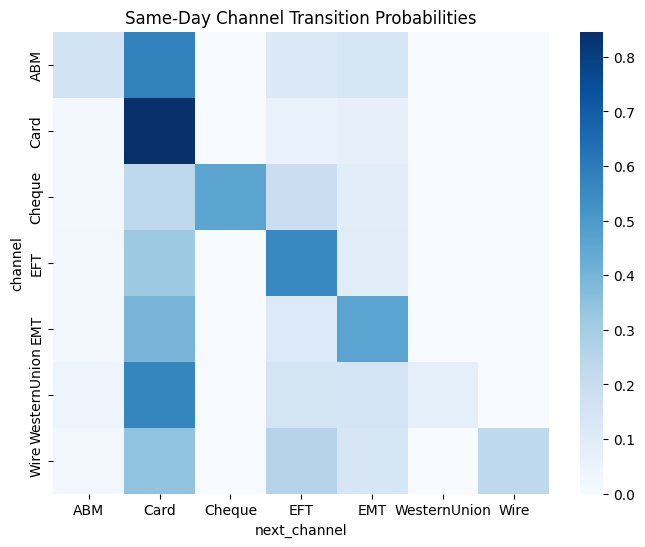

In [35]:
seq = all_txns.copy()
seq["transaction_datetime"] = pd.to_datetime(seq["transaction_datetime"], errors="coerce")
seq["date"] = seq["transaction_datetime"].dt.date

seq = seq.sort_values(["customer_id","date","transaction_datetime"])

seq["next_channel"] = seq.groupby(["customer_id","date"])["channel"].shift(-1)

transitions = (
    seq
    .dropna(subset=["next_channel"])
    .groupby(["channel","next_channel"])
    .size()
    .rename("count")
    .reset_index()
)

# normalize by origin channel
transitions["p"] = transitions.groupby("channel")["count"].transform(lambda x: x / x.sum())

transition_matrix = transitions.pivot(
    index="channel",
    columns="next_channel",
    values="p"
).fillna(0)

plt.figure(figsize=(8,6))
sn.heatmap(transition_matrix, annot=False, cmap="Blues")
plt.title("Same-Day Channel Transition Probabilities")
plt.show()

# in plot: 
# ABM -> EMT } not shown 
# EMT -> Wire } not shown 
# Card -> Card loops } shown in plot
# most same-day activity stays within the same channel (diagonal)
# EMT/EFT may be intermediate channel for laundering but no strong evidence 

## Sequence patterns by label

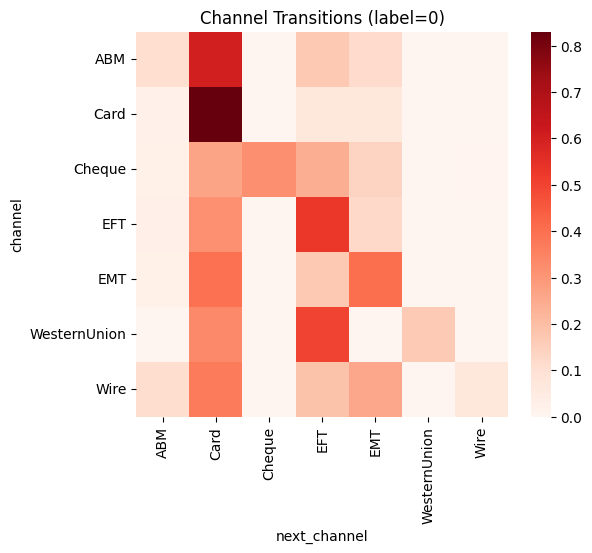

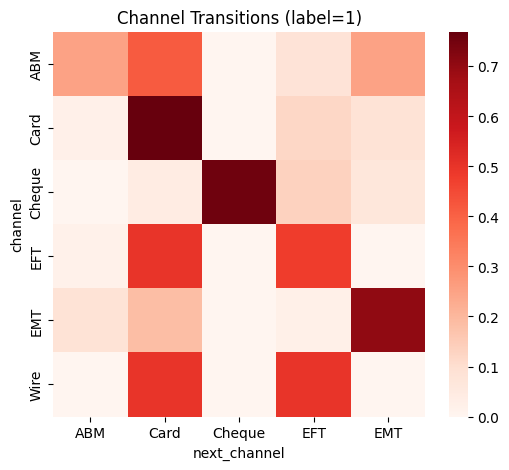

In [36]:
seq = seq.merge(label, on="customer_id", how="left")

trans_by_label = (
    seq
    .dropna(subset=["next_channel"])
    .groupby(["label","channel","next_channel"])
    .size()
    .rename("count")
    .reset_index()
)

trans_by_label["p"] = trans_by_label.groupby(["label","channel"])["count"] \
    .transform(lambda x: x / x.sum())

for lbl in [0,1]:
    mat = (
        trans_by_label[trans_by_label["label"]==lbl]
        .pivot(index="channel", columns="next_channel", values="p")
        .fillna(0)
    )
    plt.figure(figsize=(6,5))
    sn.heatmap(mat, cmap="Reds")
    plt.title(f"Channel Transitions (label={lbl})")
    plt.show()


# label=0: like above plot, normal customers tend to repeat the same channel rather than switch
# label=1: flagged customers switch channels, moving in and out of EFT and EMT 
# suggests our selected model should capture effect of both individual channels and cross-channel effects 

## Temporal compression (automation / mule signals)
- Scripted activity
- Automation
- Professional facilitation

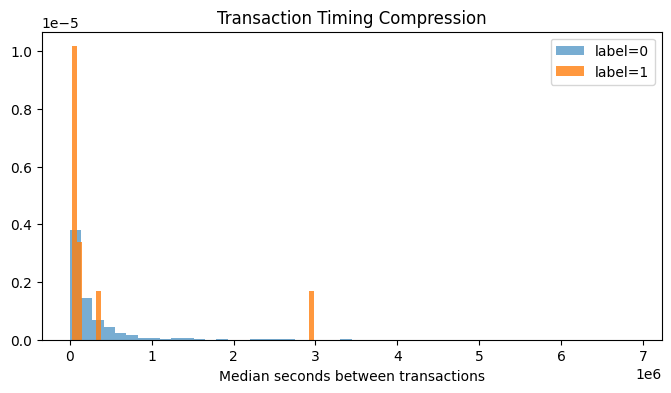

In [37]:
timing = all_txns.copy()
timing["transaction_datetime"] = pd.to_datetime(timing["transaction_datetime"], errors="coerce")
timing = timing.sort_values(["customer_id","transaction_datetime"])

timing["dt_seconds"] = (
    timing.groupby("customer_id")["transaction_datetime"]
    .diff()
    .dt.total_seconds()
)

timing_stats = (
    timing
    .groupby("customer_id")["dt_seconds"]
    .agg(
        median_gap="median",
        std_gap="std"
    )
    .reset_index()
)

timing_stats = timing_stats.merge(label, on="customer_id", how="left")

plt.figure(figsize=(8,4))
plt.hist(
    timing_stats.loc[timing_stats["label"]==0,"median_gap"],
    bins=50, alpha=0.6, density=True, label="label=0"
)
plt.hist(
    timing_stats.loc[timing_stats["label"]==1,"median_gap"],
    bins=50, alpha=0.8, density=True, label="label=1"
)
plt.xlabel("Median seconds between transactions")
plt.title("Transaction Timing Compression")
plt.legend()
plt.show()

# histogram of transaction times 
# y-axis - density of counts
# normal and flagged customers make transactions in short bursts, differences seen between groups might be due to sample size 

to capture between-channel risk, could include features like: 
- number of abm -> emt events / all abm events (and other similar paths)
- probability of emt/eft within the same day (since they're more likely intermediate step)
- ratio between abm/emt to capture odd inflow/outflow patterns 